# 教程 3：Eryn中的固定维度 MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

在第三篇教程中，我们将学习如何在 Eryn 中使用 MCMC 进行数据分析。这里会用简单例子和数据做示范，在后面的教程里，我们将使用 Eryn 处理真实的 GW 信号。

## 任务 1：建立属于自己的基本 MCMC 模型

为了更好地理解 MCMC 和 Eryn，首先为一个简单的问题构建自己的MCMC算法，使用以($\mu=0$)为中心的一维高斯似然，单位标准差($\sigma=1$)和均匀先验。

In [2]:
def log_like_gauss(x):
    return -0.5 * x ** 2 - 1/2 * np.log(2 * np.pi * 1) # 1代表单位标准差

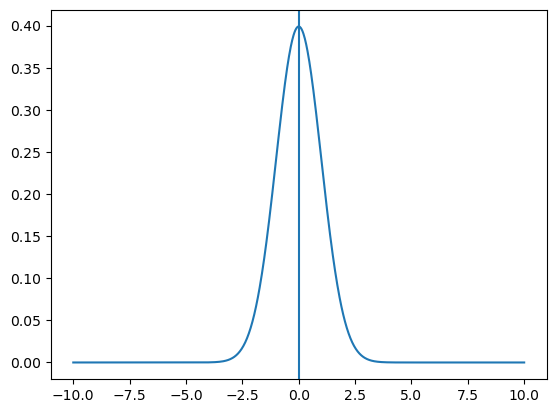

In [3]:
x_vals = np.linspace(-10.0, 10.0, 1000)
# 注意这个 `exp`，因为我们使用的是似然的对数值。
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.axvline(0.0)


将其写入一个简单的循环，并把样本存放到链表中。

In [4]:
num_steps = 100000

# 得到任意的起始值
current_point = np.random.uniform(-10.0, 10.0)
current_likelihood = log_like_gauss(current_point)
chain = []
for step in range(num_steps):
    # 利用标准偏差为 0.5 的高斯分布得到一个新的点
    # 提示: 使用正态分布抽样 current + sigma * N() where N() 
    # (np.random.randn)
    new_point = current_point + 0.5 * np.random.randn()
    
    # 得到新似然值
    new_likelihood = log_like_gauss(new_point)
    
    # 计算后验的变化
    # 这里我们使用的是统一先验，它的值不会改变，所以暂时不用管他
    # 注意prior
    delta_posterior = new_likelihood - current_likelihood  #  + (new_prior - old_prior)

    # 接受或拒绝
    # 如果对数后验变化大于 log(np.random.rand())，就接受，否则拒绝
    accept = delta_posterior > np.log(np.random.rand())

    if accept:
        current_point = new_point
        current_likelihood = new_likelihood

    chain.append(current_point)

绘制链表，注意到在开始需要一个"burn in"进程。在计算后验时，必须要去掉这些有问题的数据。有一些方法可以计算"burn in"多少数据是合适的，在这里暂时不讨论。

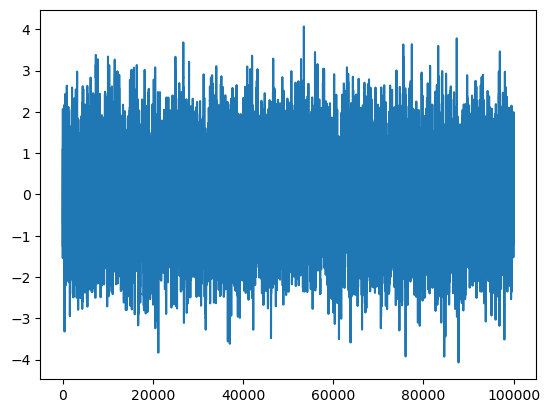

In [5]:
plt.plot(chain)

绘制 MCMC 生成的后验分布图，并与上面的真实似然值图进行比较。绘制直方图时，设置`density=True`。

换而言之， MCMC 只是从分布中抽取样本的一种方法。当样本分布像这个例子一样简单时，它其实并不需要通过MCMC 计算得出（比如在 scipy 中）。然而，在我们的工作领域，似然分布往往很难处理，这就是MCMC的用途。为了说明这一点，我们将从 Numpy 的np.random.randn中抽取样本。

(array([1.63842285e-04, 5.46140949e-04, 1.25612418e-03, 1.25612418e-03,
        1.91149332e-03, 5.18833902e-03, 8.79286928e-03, 1.43635070e-02,
        2.52317118e-02, 4.38551182e-02, 6.26423669e-02, 9.43185419e-02,
        1.22881714e-01, 1.63241530e-01, 2.11793460e-01, 2.51060994e-01,
        3.17417120e-01, 3.49584821e-01, 3.77711080e-01, 3.87923916e-01,
        3.89944638e-01, 3.87050091e-01, 3.58486919e-01, 3.09661918e-01,
        2.71377438e-01, 2.18183309e-01, 1.66572989e-01, 1.29981546e-01,
        8.57987431e-02, 5.86009238e-02, 4.01959739e-02, 2.49586414e-02,
        1.34350673e-02, 9.01132566e-03, 5.24295311e-03, 2.29379199e-03,
        2.18456380e-03, 7.09983234e-04, 3.27684569e-04, 1.09228190e-04]),
 array([-4.06920447e+00, -3.86575678e+00, -3.66230910e+00, -3.45886141e+00,
        -3.25541373e+00, -3.05196605e+00, -2.84851836e+00, -2.64507068e+00,
        -2.44162300e+00, -2.23817531e+00, -2.03472763e+00, -1.83127994e+00,
        -1.62783226e+00, -1.42438458e+00, -1.22093

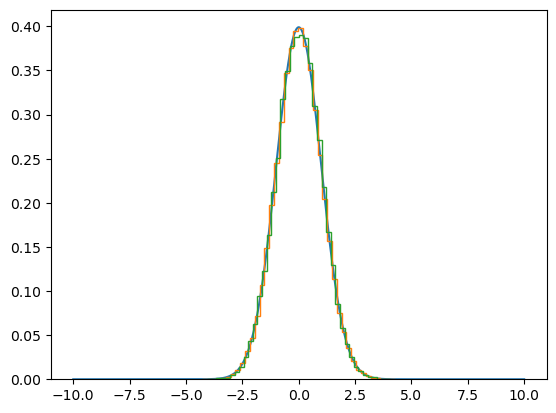

In [6]:
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.hist(np.random.randn(100000), bins=40, density=True, histtype="step")
plt.hist(chain[10000:], bins=40, density=True, histtype="step")

（MCMC和真实分布的符合情况很好）

## 任务 2：使用 Eryn 重现上述结果。

现在使用 Eryn 中的 EnsembleSampler 重现上述结果。Eryn需要定义一个先验值。使用 `uniform_dist` 创建一个简单的均匀分布。本例中只需关注 Ensemble Sampler 关键字参数。把其他的参数都设为默认值，只输入 Ensemble Sampler 参数即可。

In [7]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

初始化采样器。先验初始化的形式是`ProbDistContainer({0: prior distribution})`。

In [8]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, log_like_gauss, prior)

现在选择起点（每个行走器一个起点），可以从先验中提取或不提取。确保在最后删除所有“burn in”部分，然后将起点放入状态对象中。这里的关键是起点具有特征：（1, nwalkers, 1, ndim）。这里两个 1 分别代表温度（现在不使用）和叶或模型的数量（这是为 RJ 设置的）。完成上述操作后，运行采样器。

In [9]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

用Backend检验输出的链表。

In [10]:
end_point = sampler.run_mcmc(start_state, 10000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.96it/s]


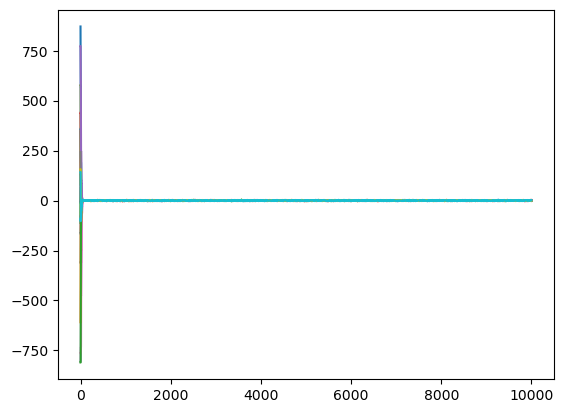

In [11]:
chain = sampler.get_chain()["model_0"]
for w in range(nwalkers):
    plt.plot(chain[:, 0, w, 0])

将输出的链表与高斯分布进行比较，两者应该相匹配。在绘制直方图时设置`density=True`。

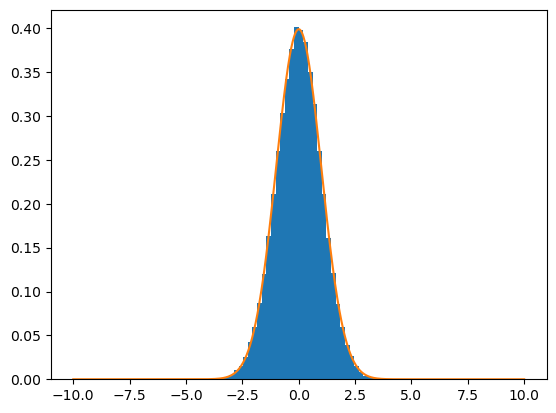

In [12]:
plt.hist(chain[1000:].flatten(), bins=40, density=True)
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

## 任务 3：并行退火

现在我们将增加并行退火。为了检验退火的效果，观察一个具有两个不同权重高斯峰的一维分布。使用提供的对数似然函数，只需要设置 x 的限值，即可对分布进行适当的归一化处理。

并行退火的工作原理是，与对数先验值相比，压低对数似然值：1/T * logL + logp。这种效果会降低峰值，使温度较高的链更容易穿过表面的低似然部分。有助于对拥有多种后验模式的分布进行正确采样。

首先在不退火的情况下进行采样，看看效果如何。然后再增加退火算法。

In [13]:
from scipy.special import logsumexp

class LogLikeTwoGuass:
    def __init__(self, x_min: float, x_max: float):
        num_for_norm = 100000
        self.norm = 1.0
        x_vals = np.linspace(x_min, x_max, num_for_norm)
        y_vals = np.array([np.exp(self.log_like_two_gauss(x_tmp)) for x_tmp in x_vals])
        self.norm = np.trapz(y_vals, x=x_vals)
        
    def log_like_two_gauss(self, x):
        return logsumexp(np.array([(np.log(0.2) + -0.5 * (x - 50.0) ** 2), (np.log(0.8) + -0.5 * (x + 50.0) ** 2)]), axis=0) - np.log(self.norm)

In [14]:
like = LogLikeTwoGuass(-1000.0, 1000.0)

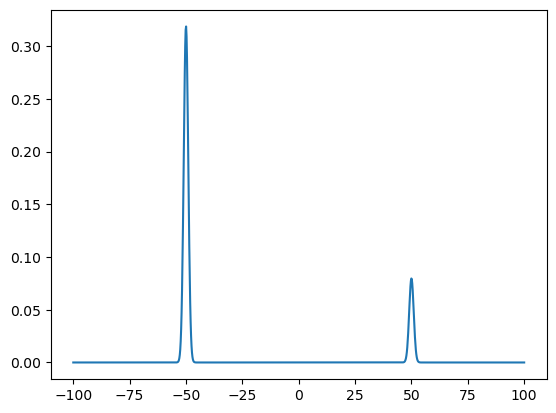

In [15]:
x_vals = np.linspace(-100.0, 100.0, 1000)
# notice the `exp` in there because we are working with the log of the likelihood.
plt.plot(x_vals, np.exp(like.log_like_two_gauss(x_vals)))
#plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))


从一个非恒定采样器开始，运行并绘制加入似然的直方图。

In [16]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, like.log_like_two_gauss, prior)
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)
sampler.run_mcmc(start_state, 10000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 279.14it/s]


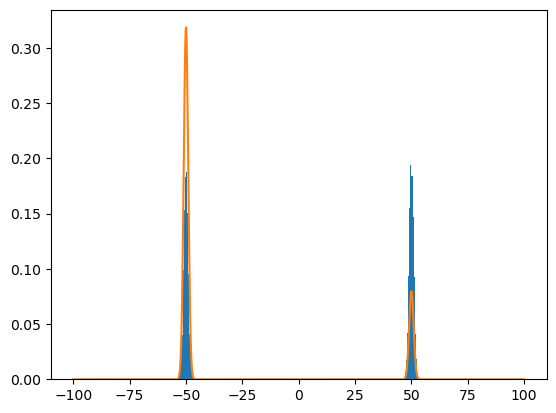

In [17]:
chain = sampler.get_chain()["model_0"][:, 0, :, 0]
plt.hist(chain[7000:].flatten(), bins=np.arange(-75., 75., 0.5), density=True)
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))

### 问题

直方图看起来并没有和分布曲线相符合。为什么？不使用退火算法时，是什么决定了每个峰值的游走者数量？

### 回答
观察采样的结果图，我们发现，它和真实的分布的区别在于，真实分布的两个峰是不等高的，而使用不退火的算法得到的峰时等高的。

因为在不使用退火算法的情况下，不包含温度这个影响因素，游走者会向峰值移动，但朝两个高斯峰移动的概率是相等的，因为没有元素反映峰的权值高低，所以不能形成完美的结果。

现在通过向`EnsembleSampler.Net`提供 tempering_kwargs kwarg 来添加温度。

In [18]:
ntemps = 10
sampler_pt = EnsembleSampler(nwalkers, 1, like.log_like_two_gauss, prior, tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf))

用 shape (ntemps, nwalkers, 1, ndim) 从先验值中再次采样起始点。然后运行采样器

In [19]:
start_point = prior.rvs(size=(ntemps, nwalkers, 1))
start_state = State(start_point)
sampler_pt.run_mcmc(start_state, 10000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:48<00:00, 59.25it/s]


在注入分布上绘制链表。

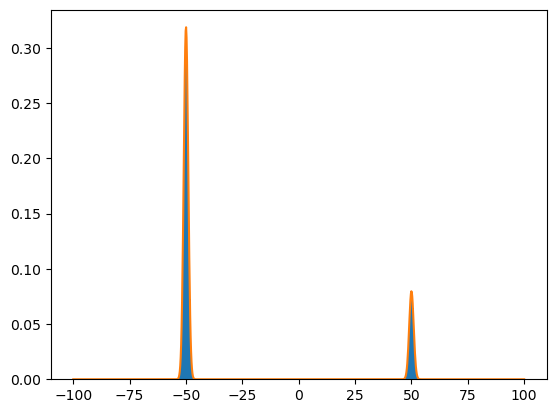

In [34]:
chain = sampler_pt.get_chain()["model_0"][:, 0, :, 0]
plt.hist(chain[1000:].flatten(), bins=np.arange(-75., 75., 0.5), density=True)
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))

现在曲线应该非常吻合。描述一下发生了什么变化。

### 回答
加入退火算法后，两峰的高低出现了区别，游走者更多地向权值更大的高斯峰游走，符合情况很好。

## 任务 6: 添加 GWs!

生成注入数据，将其输入 DataResidualArray，加载 SensitivityMatrix，并将所有内容（包括正弦波形发生器）存储在 AnalysisContainer 中。

In [20]:
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import SensitivityMatrix, LISASens

加入波形。

In [21]:
def sinusoidal_waveform(A: float, f0: float, phi0: float, t: np.ndarray, **kwargs) -> [np.ndarray, np.ndarray]:
    h1 = A * np.sin(2 * np.pi * (f0 * t) + phi0)
    h2 = A * np.cos(2 * np.pi * (f0 * t) + phi0)
    return [h1, h2]

生成插入的数据，将它输入DataResidualArray中，加载SensitivityMatrix，并把它们都存进AnalysisContainer中，包括正弦波形生成器。

In [22]:
dt = 10.0
t_arr = np.arange(100000) * dt
data = DataResidualArray(sinusoidal_waveform(1e-21, 2e-3, np.pi / 3, t_arr), dt=dt)
sens_mat = SensitivityMatrix(data.f_arr, [LISASens, LISASens])
analysis = AnalysisContainer(data, sens_mat, signal_gen=sinusoidal_waveform)

/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3

计算注入的信噪比。(AnalysisContainer.calculate_signal_snr)

In [23]:
analysis.calculate_signal_snr(1e-21, 2e-3, 0.0, t_arr)

(30.849156386054677, 15.424578193023093)

计算三个参数的先验分布。

In [24]:
priors = ProbDistContainer({
    0: uniform_dist(9e-22, 3e-21),
    1: uniform_dist(1.5e-3, 2.5e-3),
    2: uniform_dist(0.0, 2 * np.pi)
})

初始化采样器。似然函数可以使用 AnalysisContainer.eryn_likelihood_function。现阶段我们将不会使用退火方法，因为这种方案效率不高。所以仅作为一个快速示例运行。我们可以让它运行更长的时间或利用 Eryn 的pool功能将其并行化。这个基本示例说明了快速波形生成功能的必要性。

In [25]:
ndim = 3
sampler = EnsembleSampler(
    nwalkers,
    ndim, 
    analysis.eryn_likelihood_function,
    priors,
    args=(t_arr,)
)

生成初始状态并运行采样器。

In [26]:
start_state = State(priors.rvs(size=(1, nwalkers, 1)))
sampler.run_mcmc(start_state, 100, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


可以依照需求检查链表或似然值，但可能需要运行更长时间才能得到合理的结果。

### 问题

我们可以做些什么来加快计算速度？将其转换到波形环境中。

### 回答
将退化算法并行化。

## 任务 4：计算证据率

用 Eryn 的热力学积分计算单峰高斯分布的证据率。首先使用 10 个游走者和 50 个温度（这些的数量可以稍后调整），观察它们对测量的影响。运行 run_mcmc 时使用burn kwarg。重点：对于EnsembleSampler的退火_kwargs关键字参数，必须在字典中添加：stop_adaptation=burn。这将在burn in过程中调整温度并且在记录样本时保持温度不变。

In [27]:
# imports
from eryn.utils.utility import thermodynamic_integration_log_evidence

初始化采样器，运行MCMC。

In [28]:
nwalkers = 10
ntemps = 50
burn = 2000
sampler_pt_2 = EnsembleSampler(nwalkers, 1, log_like_gauss, prior, tempering_kwargs=dict(stop_adaptation=burn, ntemps=ntemps, Tmax=np.inf))

start_point = prior.rvs(size=(ntemps, nwalkers, 1))
start_state = State(start_point)
sampler_pt_2.run_mcmc(start_state, 10000, burn=burn, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 88.77it/s]


1) 计算每个温度链表中所有样本和游走者的平均似然。
2) 从采样器后台获取反温度（betas），并确保它们在整个运行过程中都是相同的。
3) 计算证据率

In [29]:
logl_avg = sampler_pt_2.get_log_like().mean(axis=(0, 2))
betas = sampler_pt_2.get_betas()[-1]
assert np.all(betas == sampler_pt_2.get_betas()[0])
logz = thermodynamic_integration_log_evidence(betas, logl_avg)
print(logz)

(-16.39232439992184, 84.87464805782193)


## 任务 5：模型选择

用热力学积分得出的证据率对高斯脉冲和柯西脉冲进行模型比较。

下面是脉冲函数和似然。我们假设每个脉冲都有一个振幅和平均参数。将标准偏差设为 1。

In [30]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

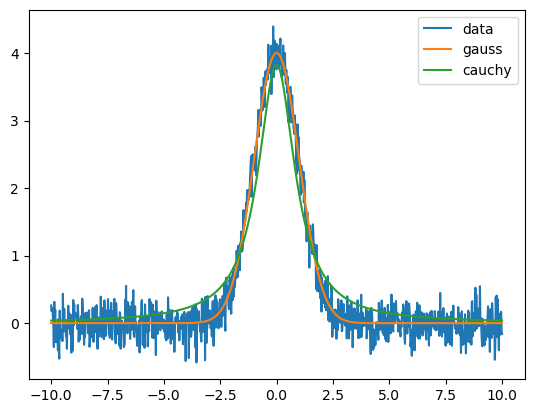

In [31]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 0.2
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

每个模型运行不同的采样器对象。
两个模型的先验其实是相同的。振幅先验的范围是注入值。平均值先验的范围是时间域。

为每个模型初始化先验，为每个模型初始化采样器，为每个模型采样一个起始点，然后按照上面的设置运行两个采样器。

In [32]:
priors = {}
samplers = {}
burn = 1000
for name in ["gauss", "cauchy"]: 
    priors[name] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
})
    samplers[name] = EnsembleSampler(
        nwalkers,
        2,
        log_like_fn,
        priors,
        branch_names=[name],
        tempering_kwargs=dict(stop_adaptation=burn, ntemps=ntemps, Tmax=np.inf),
        args=(t_vals, data, sigma, name)
    )

    start_point = priors[name].rvs(size=(ntemps, nwalkers, 1))
    start_state = State({name: start_point})
    samplers[name].run_mcmc(start_state, 10000, burn=burn, progress=True)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:53<00:00, 14.02it/s]


对两个模型重复上面的计算。然后找出贝叶斯因子。

In [33]:
logz_out = {}
for name in ["gauss", "cauchy"]: 
    logls = samplers[name].get_log_like().mean(axis=(0, 2))
    betas = samplers[name].get_betas()
    assert np.all(betas[-1] == betas[0])
    logz, dlogz = thermodynamic_integration_log_evidence(betas[0], logls)
    print(name, logz, dlogz)
    logz_out[name] = logz

print("2log(Bayes Factor):", 2 * (logz_out["gauss"] - logz_out["cauchy"]))

gauss -486.3362975858834 39.367722299674654
cauchy -1019.8369574561889 32.60424611741473
2log(Bayes Factor): 1067.001319740611


### 问题

如果改变噪声，结果会有什么影响？

### 回答

柯西脉冲适合于比较扁、宽的曲线，
高脉冲布则适合较高、较窄的曲线。
如果增加噪声，对于这些模型，可能出现特征不明显，过拟合等情况。

## 学习总结

在这章节内容中，我学习了MCMC算法的基础知识，并且使用一些简单的示例进行了练习，以下是我的思考：

1) MCMC的原理：MCMC是一种抽样方法，通过从现在的分布中抽取样本，通过概率论中的最大似就是参数估计中的最大似然估计然推断原样本的分布类型，可以用来处理引力波数据分析领域一些比较复杂，不能之间看出的分布。

2) Eryn：这个包里的内容可以帮助我们更方便地使用MCMC方法计算分布，背后的原理应该是最优化方法，通过确定行走规则和初始位置，到达最优解的位置，可以有效地算出单峰分布的分布情况。

3) 并行退火：这是对上述Eryn中实现的算法的优化，通过模拟物理情况下的退火过程（即增加了一个温度值），可以算出不同权值多峰的具体分布情况，准确度更高，但是单一的模拟退火算法效率较低，最好增加并行化的过程，加快计算速度，这个问题我暂时还没有解决，需要继续学习。

4) 模型选择：在拟合时，我们有两种模型：高斯脉冲和柯西-洛伦兹脉冲可以描述一个中心峰分布，柯西脉冲适合于比较扁、宽的曲线， 高脉冲布则适合较高、较窄的曲线。我们应该根据不同的情况判断一个拟合函数，在上面编写的示例里，高斯脉冲的拟合情通过这部分学习，了解了高斯脉冲和柯西脉冲，以及在不同情况下如何选择模型的问题和要考虑的因素，比如贝叶斯因子。